<a href="https://colab.research.google.com/github/vladke95/Job_test/blob/main/Rb_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [597]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

# Plot constants and colors
BAR_COLOR  = '#e66707'
BAR_COLOR2 = '#a32c1a'
BAR_COLOR3 = '#309e15'
TICK_COLOR = '#ffffff'
TITLE_FONT_SIZE= 16
LABEL_FONT_SIZE= 14
################################

# Training and testing data loading
# I loaded data from google drive, also my data is modified, 
# not original, so that income and balance numbers are dot 
# separeted and not coma separated.

train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RB/Retail_data_v02.csv')
test_df  = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RB/Potential_Customers_v02.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We are going to discuss each feature to see how should they affect Mortgage and what to expect while analysing the results that model going to give.


Cocunut is some sort of ID. It doesn't affect Mortgage.

Age at which person take Morgage should replace current Age for people who took Morgage. And then Age at origination will not be considered and modified Age will.

Years with bank, Martial status, Education, Employment, Gender, Customer income and Current balance should all have correlation with Mortgage, some with stronger, some with weaker correlation.

For Address, Job and Bank Date we are going to extract only year and check correlations. Since Bank date and Years with bank carry same info we will not consider Bank date.


In [598]:
# @title
# Data formating

# Remaping Mortgage data to 0 and 1 

train_df['Mortgage_YN'] = train_df['Mortgage_YN'].map( {'N': 0, 'Y': 1} ).astype(int)

# Replacing Age for people who took Mortgage with age when they took it, and
# droping AGE_AT_ORIGINATION feature

mort_y_n = train_df['Mortgage_YN'].value_counts()[1]
for i in range(mort_y_n):
    train_df.loc[i, 'AGE'] = int(train_df['AGE_AT_ORIGINATION'][i])

train_df  = train_df.drop(['AGE_AT_ORIGINATION'], axis=1)

train_df.head()

,Cocunut,Mortgage_YN,AGE,YEARS_WITH_BANK,MARTIAL_STATUS,EDUCATION,EMPLOYMENT,GENDER,CUST_INCOME,CURRENT_ADDRESS_DATE,CURRENT_JOB_DATE,CURRENT_WITH_BANK_DATE,CURRENT_BALANCE_EUR
0,1,1,50,13,M,HGH,PVE,M,909.501308,4/18/1979,1/1/2010,3/16/2004,7648.350692
1,9,1,48,11,M,HGH,SFE,M,288.461538,12/16/1999,1/20/2004,11/7/2005,30189.904920
2,11,1,53,14,M,BCR,STE,M,1280.528692,6/28/2005,9/1/1990,6/25/2003,50553.174540
3,12,1,64,10,M,BCR,OTH,F,620.959769,12/22/2000,10/1/9999,12/21/2006,15907.283380
4,18,1,46,9,S,MAS,PVE,F,2239.853846,8/1/2009,12/24/2013,8/7/2007,27916.192620


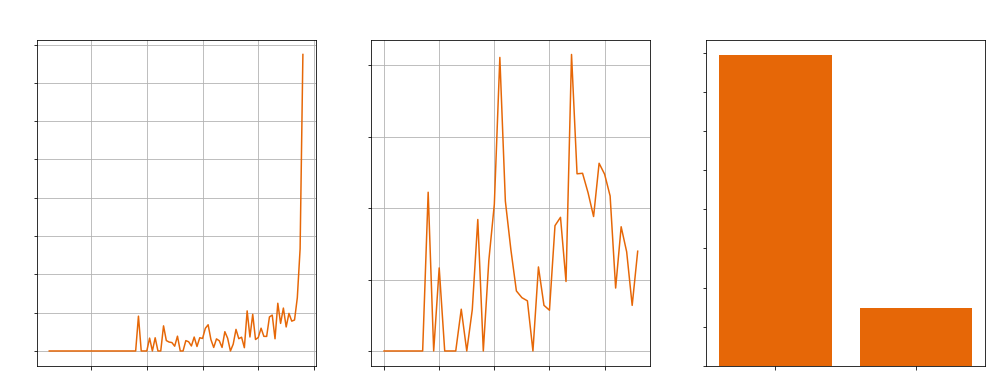

In [599]:
# @title
# Fromating dates data and Analysing them

train_df['CURRENT_ADDRESS_DATE'] = train_df['CURRENT_ADDRESS_DATE'].astype(str)
train_df['CURRENT_JOB_DATE'] = train_df['CURRENT_JOB_DATE'].astype(str)
train_df['CURRENT_WITH_BANK_DATE'] = train_df['CURRENT_WITH_BANK_DATE'].astype(str)

train_df['CURRENT_ADDRESS_DATE_YEAR'] = train_df['CURRENT_ADDRESS_DATE'].str[-4:].astype(int)
train_df['CURRENT_JOB_DATE_YEAR'] = train_df['CURRENT_JOB_DATE'].str[-4:].astype(int)
train_df['CURRENT_WITH_BANK_DATE_YEAR'] = train_df['CURRENT_WITH_BANK_DATE'].str[-4:].astype(int)

plt.figure(figsize=(17, 6))
k=131
ftr = ['CURRENT_ADDRESS_DATE_YEAR', 'CURRENT_JOB_DATE_YEAR']
titles = ['current address date', 'current job date']
for i in range(2):
    plt.subplot(k+i)
    tmp = train_df[[ftr[i], 'Mortgage_YN']].groupby([ftr[i]], as_index=False).mean().sort_values(by=ftr[i], ascending=True)
    tmp = tmp[tmp[ftr[i]]<2025]
    plt.plot(tmp[ftr[i]],tmp['Mortgage_YN']*100, color=BAR_COLOR)
    plt.title("Mortgage chance by " + titles[i] + " (%)\n", fontsize=TITLE_FONT_SIZE*0.9, color=TICK_COLOR)
    plt.xticks(color=TICK_COLOR)
    plt.yticks(color=TICK_COLOR)
    plt.grid(axis='both')

# We are going to change 208 values in CURRENT_ADDRESS_DATE_YEAR that 
# are above 2021 to median value since Address year doesnt show much of 
# correlation, and most of them didn't took mortgage

tmp = train_df['CURRENT_ADDRESS_DATE_YEAR'].median()
train_df.loc[train_df['CURRENT_ADDRESS_DATE_YEAR']>2021,'CURRENT_ADDRESS_DATE_YEAR'] = tmp

# There are around 24% of samples with CURRENT_JOB_DATE year value of 
# 9999. (I think that value means someone doesn't have a job, but on 
# the other hand income may not be 0, which means they are earning 
# money while not registered in state employment center, or simply data was not colected.)

# We will drop row where CURRENT_WITH_BANK_DATE year is 1976 (1550. row)
# since it's probably a mistake. Also since YEARS_WITH_BANK and 
# CURRENT_WITH_BANK_DATE_YEAR carry same info, we can drop
# CURRENT_WITH_BANK_DATE_YEAR. We will also drop all dates since we 
# dont need them anymore. Before droping features, we are going 
# to create new feature called HAVE_JOB which will replace 
# CURRENT_JOB_DATE_YEAR feature.

train_df['HAVE_JOB'] = (train_df['CURRENT_JOB_DATE_YEAR']/9000).astype(int)
test_df['HAVE_JOB'] = ((test_df['CURRENT_JOB_DATE'].astype(str)).str[-4:].astype(int)/9000).astype(int)

test_df['CURRENT_ADDRESS_DATE_YEAR'] = test_df['CURRENT_ADDRESS_DATE'].astype(str).str[-4:].astype(int)
test_df.loc[test_df['CURRENT_ADDRESS_DATE_YEAR']>2021,'CURRENT_ADDRESS_DATE_YEAR'] = tmp
test_df = test_df.drop(['CURRENT_ADDRESS_DATE','CURRENT_JOB_DATE',\
                          'CURRENT_WITH_BANK_DATE'], axis=1)

train_df = train_df.drop([1550])
train_df = train_df.drop(['CURRENT_JOB_DATE_YEAR'], axis=1)
train_df = train_df.drop(['CURRENT_WITH_BANK_DATE_YEAR'], axis=1)
train_df = train_df.drop(['CURRENT_ADDRESS_DATE','CURRENT_JOB_DATE',\
                          'CURRENT_WITH_BANK_DATE'], axis=1)

plt.subplot(133)
tmp = train_df[['HAVE_JOB', 'Mortgage_YN']].groupby(['HAVE_JOB'], as_index=False).mean().sort_values(by='HAVE_JOB', ascending=True)
plt.bar(tmp['HAVE_JOB'],tmp['Mortgage_YN']*100, color=BAR_COLOR)
plt.title("Mortgage chance by " + "Job Status" + " (%)\n", fontsize=TITLE_FONT_SIZE*0.9, color=TICK_COLOR)
plt.xticks(tmp['HAVE_JOB'],['Have job','Jobless'],color=TICK_COLOR)
plt.yticks(color=TICK_COLOR)
print('')

On the graphs above we can see how address date and job date affect chances of taking Mortgage.

On the left graph we see that people who bought home more recent have much higher chance of taking mortgage to buy that home.

On the middle graph we see that job date for people with jobs have a lot of variance so we will can ignore that info. However around 1/4 of the analysed people doesn't have a job and that people are less likely to take mortgage. We can see that on the right graph.

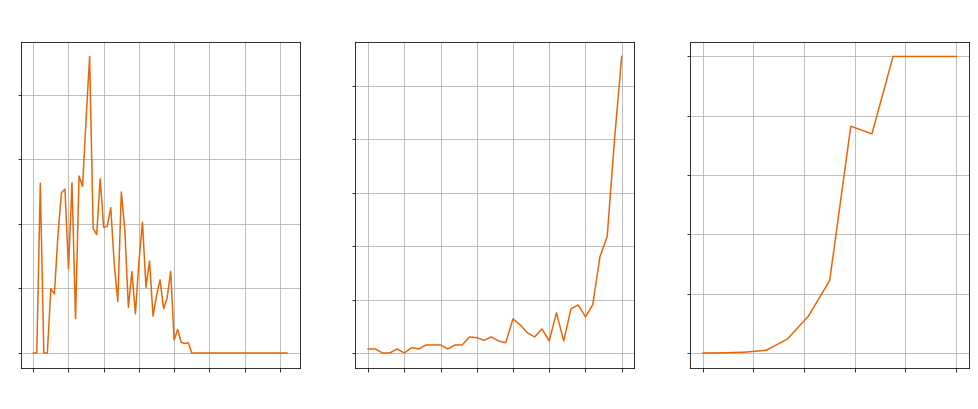

In [600]:
# @title
# Age, Balance and Income analysis

train_df['CUST_INCOME_BANDS'] = pd.qcut(train_df['CUST_INCOME'], 36, labels=False)
# TODO xlabels to interval mid
train_df['CURRENT_BALANCE_EUR_BANDS'] = pd.cut(train_df['CURRENT_BALANCE_EUR'], 90, labels=False)

plt.figure(figsize=(17, 6))
k=131
ftr = ['AGE','CUST_INCOME_BANDS', 'CURRENT_BALANCE_EUR_BANDS']
titles = ['age', 'income bands','balance']
xlabels = ['years','EUR','EUR']
right_x_border = [100,10000,13]
for i in range(3):
    plt.subplot(k+i)
    tmp = train_df[[ftr[i], 'Mortgage_YN']].groupby([ftr[i]], as_index=False).mean().sort_values(by=ftr[i], ascending=True)
    tmp = tmp[tmp[ftr[i]]<right_x_border[i]]
    q=1
    if(i==2):
      q = 188000/90
    plt.plot(tmp[ftr[i]]*q,tmp['Mortgage_YN']*100, color=BAR_COLOR)
    plt.title("Mortgage chance by " + titles[i] + " (%)\n", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
    plt.xticks(color=TICK_COLOR)
    plt.xlabel(xlabels[i], color=TICK_COLOR, fontsize=TITLE_FONT_SIZE*0.8)
    plt.yticks(color=TICK_COLOR)
    plt.grid(axis='both')

People above 65 doesn't take mortgage and thats a strong correlation which says if a person is above 65 we won't consider him for mortgage without further analysis. As people get older they are less likely to take mortgage.

As expected people with bigger income are more suited for mortgage.

Around 1/6 of people have less then 50 EUR on account, and around 1/8 have 0. There are less than 0.6% of people with 30000 EUR or more on account. 

36% of people who have between 10k and 20k EUR on their account took mortgage, and between 20k and 30k EUR all people took mortgage. So balance is strong correlation because if person have more than 20k EUR he can be consider for mortgage without further analysis.

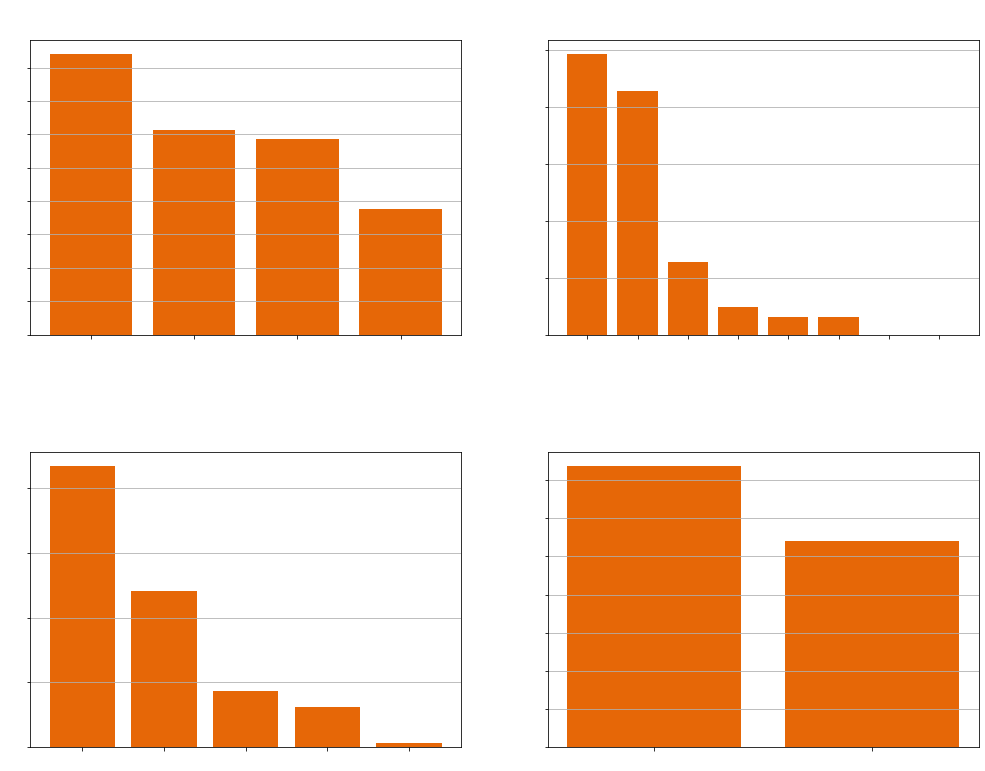

In [601]:
#@title
# MARTIAL_STATUS, EDUCATION, EMPLOYMENT, GENDER Analysis and further formating

# since there are 43 noval and MARTIAL_STATUS doesn't seem like a strong
# correlation we are going to simply replace nonval with M

train_df.loc[train_df['MARTIAL_STATUS']=='*noval*','MARTIAL_STATUS'] = 'M'
test_df.loc[test_df['MARTIAL_STATUS']=='*noval*','MARTIAL_STATUS'] = 'M'

plt.figure(figsize=(17, 13))
plt.subplots_adjust(hspace = 0.4)
k=221
for ftr in ['MARTIAL_STATUS', 'EDUCATION', 'EMPLOYMENT', 'GENDER']:
    tmp = train_df[[ftr, 'Mortgage_YN']].groupby([ftr], as_index=False).mean().sort_values(by='Mortgage_YN', ascending=False)
    plt.subplot(k)
    k+=1
    plt.bar(tmp[ftr],tmp['Mortgage_YN']*100, color=BAR_COLOR)
    plt.title("Mortgage chance by " + ftr + " (%)\n", fontsize=TITLE_FONT_SIZE*0.9, color=TICK_COLOR)
    plt.xticks(color=TICK_COLOR)
    plt.yticks(color=TICK_COLOR)
    plt.grid(axis='y')

# Creating artificial features (morphing 2 storng correlations into even 
# stronger one) could help and simplify model, but I won't do it here since I 
# want to see how original features perform.

# We are going to remap feature labels to numbers, there is TEA label in
# EMPLOYMENT feature in test_data, and since it has not showed up in the train
# data we won't be confident when analysing people with TEA label. However we
# could ignore it for now till we gather more data with TEA label. For now
# we will replace them with the most common one which is PVE (or we can drop 
# them since working with unknown data could be risky).

test_df.loc[test_df['EMPLOYMENT']=='TEA','EMPLOYMENT'] = 'PVE'

train_and_test = [train_df,test_df]
for dataset in train_and_test:
    dataset['MARTIAL_STATUS'] = dataset['MARTIAL_STATUS'].map( {'S': 3, 'M': 2, 'D': 1, 'W': 0} ).astype(int)
    dataset['EDUCATION'] = dataset['EDUCATION'].map( {'MAS': 3, 'PHD': 3, 'BCR': 2, 'SEC': 1, 'PRS': 1, 'HGH': 1, 'OTH': 1, 'PRI': 1} ).astype(int)
    dataset['EMPLOYMENT'] = dataset['EMPLOYMENT'].map( {'SFE': 4, 'OTH': 3, 'PVE': 2, 'STE': 1, 'RET': 0} ).astype(int)
    dataset['GENDER'] = dataset['GENDER'].map( {'M': 1, 'F': 0} ).astype(int)

From the graphs above we can drawn some conclusions.

Martial status have a little correlation on mortage. Education and Employment have huge correlation (I don't know what Employment feature represents). Gender have low correlataion and only says that Males are around 30% more likely to have mortgage.

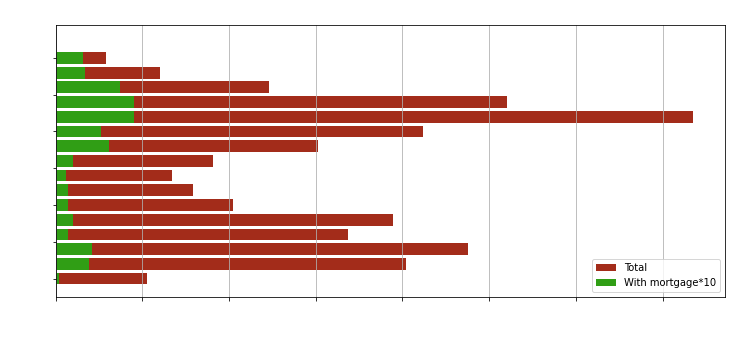

In [602]:
#@title
# YEARS_WITH_BANK feature analysis

ftr = 'YEARS_WITH_BANK'

x = []
y = []
for i in train_df['YEARS_WITH_BANK'].unique():
    tmp = train_df[train_df['YEARS_WITH_BANK']==i]
    x.append(i)
    y.append(tmp[tmp['Mortgage_YN']==1].count()[0]*10)

plt.figure(figsize=(12, 5))
tmp = train_df['YEARS_WITH_BANK'].value_counts().sort_values(ascending=True)
plt.barh(tmp.index,tmp,color=BAR_COLOR2)
plt.barh(x,y,color=BAR_COLOR3)
plt.title("Number of people per spent years with bank", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
plt.legend(['Total','With mortgage*10'], loc="lower right")
plt.xticks(color=TICK_COLOR)
plt.xlabel('Number of people', color=TICK_COLOR, fontsize=TITLE_FONT_SIZE)
plt.ylabel('Years with bank', color=TICK_COLOR, fontsize=TITLE_FONT_SIZE)
plt.yticks(color=TICK_COLOR)
plt.grid(axis='x')

As expected from graph above we can see that people who spent more time with a bank are more likely to take a mortgage.

Now we are going to make  exploratory model.

In [606]:
#@title

# Here we will complete our train and test data for exploratory data anlysis.

train_df = train_df.drop(['Cocunut','CUST_INCOME_BANDS','CURRENT_BALANCE_EUR_BANDS'], axis=1)
test_df = test_df.drop(['Cocunut'], axis=1)
train_and_test = [train_df,test_df]

# x_train, y_train, x_test creating from existing dataframe

x_train = train_df.drop("Mortgage_YN", axis=1)
y_train = train_df["Mortgage_YN"]
x_test  = test_df.copy()
# From now on we are going to do exploratory data anlysis.

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import ShuffleSplit,cross_validate

ML_Algs = [
            DecisionTreeClassifier(),
            RandomForestClassifier(n_estimators=100),
            KNeighborsClassifier(n_neighbors = 3),
            GaussianNB(),
            SVC(),
            XGBClassifier(),
            Perceptron(),
            SGDClassifier()
]

ML_Algs_table_columns = [
                         'Algorithm',
                         'Train_Accuracy',
                         'Test_Accuracy',
                         'Test_Accuracy_std*3',
                         'Time'
]

ML_Algs_table = pd.DataFrame(columns = ML_Algs_table_columns)
cv_split = ShuffleSplit(n_splits = 10, test_size = 0.25, train_size = 0.75, random_state = 0)
k=0
for alg in ML_Algs:
    cv_results = cross_validate(alg, x_train, y_train, cv=cv_split, return_train_score=True)
    ML_Algs_table.loc[k,'Algorithm'] = alg.__class__.__name__
    ML_Algs_table.loc[k,'Train_Accuracy'] = round(cv_results['train_score'].mean() * 100, 2) 
    ML_Algs_table.loc[k,'Test_Accuracy'] = round(cv_results['test_score'].mean() * 100, 2) 
    ML_Algs_table.loc[k,'Test_Accuracy_std*3'] = round(cv_results['test_score'].std()*3, 3)
    ML_Algs_table.loc[k,'Time'] = round(cv_results['fit_time'].mean(), 3)
    k+=1

ML_Algs_table.sort_values(by = ['Test_Accuracy'], ascending=False)

,Algorithm,Train_Accuracy,Test_Accuracy,Test_Accuracy_std*3,Time
5,XGBClassifier,99.87,99.8,0.001,0.882
2,KNeighborsClassifier,99.82,99.79,0.001,0.031
1,RandomForestClassifier,100,99.78,0.001,1.451
4,SVC,99.78,99.76,0.001,0.198
0,DecisionTreeClassifier,100,99.65,0.002,0.057
6,Perceptron,99.52,99.54,0.009,0.031
7,SGDClassifier,99.46,99.47,0.019,0.078
3,GaussianNB,98.66,98.62,0.006,0.01


At first 99.8% seems like realy good accuracy, but if we remmember we had only 306 Y out of around 24000 samples which means if model guessed N everytime he would still hit around 98.72%.

In [596]:
#@title
# In this part I banded some parameters but accuracy was lower so I decided to
# go with original values

# # Here we will complete our train and test data for exploratory data anlysis.
# # The problem is CURRENT_BALANCE_EUR because it's important feature, but 
# # umbalanced data, so we will have to manualy band the data. 

# train_and_test = [train_df,test_df]
# k=[10,8,10,8]
# ftr=['CUST_INCOME', 'AGE', 'CURRENT_ADDRESS_DATE_YEAR', 'YEARS_WITH_BANK']
# ftr_bands=['CUST_INCOME_BANDS', 'AGE_BANDS', 'CURRENT_ADDRESS_DATE_YEAR_BANDS', 'YEARS_WITH_BANK_BANDS']
# for i in range(4):
#     tmp_bands = pd.qcut(train_df[ftr[i]], k[i])
#     for dataset in train_and_test:
#         for j in range(k[i]):
#             l = tmp_bands.unique().sort_values()[j].left
#             r = tmp_bands.unique().sort_values()[j].right
#             dataset.loc[ (dataset[ftr[i]] > l) & (dataset[ftr[i]] <=r), ftr_bands[i]] = j
#         dataset[ftr_bands[i]] = dataset[ftr_bands[i]].astype(int)
# train_and_test = [train_df,test_df]
    
# for dataset in train_and_test:
#     dataset.loc[ dataset['CURRENT_BALANCE_EUR'] <= 2000, 'CURRENT_BALANCE_EUR_BANDS'] = 0
#     k=1
#     for i in [[2000,4000], [4000,7000], [7000,10000], [10000,15000], [15000,20000]]:
#         dataset.loc[(dataset['CURRENT_BALANCE_EUR'] > i[0]) & (dataset['CURRENT_BALANCE_EUR'] <= i[1]), 'CURRENT_BALANCE_EUR_BANDS'] = k
#         k+=1
#     dataset.loc[ dataset['CURRENT_BALANCE_EUR'] > 20000, 'CURRENT_BALANCE_EUR_BANDS'] = k

#     dataset['CURRENT_BALANCE_EUR_BANDS'] = dataset['CURRENT_BALANCE_EUR_BANDS'].astype(int)

# train_df = train_df.drop(['Cocunut','CUST_INCOME','AGE','YEARS_WITH_BANK', 'CURRENT_ADDRESS_DATE_YEAR', 'CURRENT_BALANCE_EUR'], axis=1)
# test_df = test_df.drop(['Cocunut','CUST_INCOME','AGE','YEARS_WITH_BANK', 'CURRENT_ADDRESS_DATE_YEAR', 'CURRENT_BALANCE_EUR'], axis=1)
# train_and_test = [train_df,test_df]